In [1]:
library(boot)

In [2]:
# function that generates random draw for data of specified length
random_draw <- function(ndata) {
  gen_y <- data.frame()
  n = ndata
  delta <- rbinom(n,1,prob=0.6)
  beta <- c(-1, -1, 1/2)
  x.1 <- rchisq(n, df = 4)
  x.2 <- rchisq(n, df = 2)
  x <- ifelse(delta == 1, x.1, x.2)
  lambda.hat <- exp(beta[1] + beta[2]*delta + beta[3]*x)
  df <- as.data.frame(cbind(lambda.hat, delta, x))
  Y <- rpois(ndata, lambda = lambda.hat)
  df <- as.data.frame(cbind(Y, df))
  df
}

In [3]:
set.seed(10)
pois.data = random_draw(1000)

**Delta-Method**

In [4]:
# # Functions for delta-method fxn 

numerical.derivative<- function(fun,x) {
    nn <- length(x)
    dx <- rep(NaN, nn)
    for (i in 1:nn) {
        eps <- rep(0,nn)
        eps[i] <- 1e-6
        dx[i] <- (fun(x+eps)-fun(x-eps))/(2e-6)
        }
    return(dx)
}

# Return the probability of a 1 or 0 when x1=1, and  x2=4
prob.pois.0 <-  function( beta ) {
    dpois(0,lambda=exp(beta[1]+beta[2]+4*beta[3])) + dpois(1,lambda=exp(beta[1]+beta[2]+4*beta[3]))
} 

In [5]:
# function that conducts a GLM estimate for each draw and constructs confidence intervals for parameters and transformation

delta_method_ <- function(data){
    # run GLM function (linear predictor)
    df = as.data.frame(data)
    glm.output <- glm(Y ~ delta + x, data = df, family="poisson")
    beta.hat <- coef(glm.output)
    sigma.hat <- vcov(glm.output) # (how much variability do we have on the parameter)
    fitted.values <- glm.output$fitted.values 
    linear.predictors <- glm.output$linear.predictors
    
    # gather confidence intervals of parameters
    confint95=data.frame(confint(glm.output, level=.95))
    colnames(confint95)<-c(2.5, 97.5)
    confint90=data.frame(confint(glm.output, level=.9))
    colnames(confint90)<-c(5, 95)
    confint80=data.frame(confint(glm.output, level=.8))
    colnames(confint80)<-c(10, 90)
    delta.results<- cbind(confint95, confint90)
    delta.results<-cbind(delta.results, confint80)
    delta.results['estimate']<-beta.hat

    # # measure confidence intervals for transformation
    dG <- numerical.derivative(prob.pois.0, beta.hat) # partial derivative with respect to probability
    vcov.g <- t(dG)%*%sigma.hat%*% dG # Get the Delta method vcov matrix
    
    delta.method.out <- c("estimate_prob" = prob.pois.0(beta.hat),
                      "est_lowconf97.5"= prob.pois.0(beta.hat)-1.96*sqrt(vcov.g),
                      "est_highconf97.5"= prob.pois.0(beta.hat)+1.96*sqrt(vcov.g),
                      "est_lowconf95"= prob.pois.0(beta.hat)-1.645*sqrt(vcov.g),
                      "est_highconf95"= prob.pois.0(beta.hat)+1.645*sqrt(vcov.g),
                      "est_lowconf90"= prob.pois.0(beta.hat)-1.282*sqrt(vcov.g),
                      "est_highconf90"= prob.pois.0(beta.hat)+1.282*sqrt(vcov.g))
    
    results <- rbind(delta.results, delta.method.out)
    rownames(results) <- c("intercept", "b0", "b1", "transformation")
    results <-results[, c(7,1,2,3,4,5,6)]
    return (results)
}

In [6]:
delta_method_(pois.data)

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...



,estimate,2.5,97.5,5,95,10,90
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
intercept,-1.0124234,-1.0931425,-0.9329087,-1.0800829,-0.9456122,-1.0650654,-0.9602967
b0,-1.0244556,-1.0902828,-0.9581011,-1.0797339,-0.9688059,-1.0675555,-0.9811302
b1,0.5028935,0.4962229,0.5095932,0.4972935,0.5085140,0.4985286,0.5072708
transformation,0.7595463,0.7449503,0.7226352,0.7672655,0.7262215,0.7636791,0.7303544


**Bootstrap Method**

In [7]:
# # Functions for boostrap fxn

# Return the probability of a 1 or 0 when x1=1, and  x2=4
prob.pois.0 <-  function( beta ) {
    dpois(0,lambda=exp(beta[1]+beta[2]+4*beta[3])) + dpois(1,lambda=exp(beta[1]+beta[2]+4*beta[3]))
} 

# defining function to generate data and return parameter coefficients
pois.bootstrap <- function(formula, data, indices) {
  d <- data[indices,]
  pois.fit <- glm(formula, data=d, family="poisson")
  return(coef(pois.fit))
}

# defining function to generate data and return transformation output
pois.bootstrap.transformation <- function(formula, data, indices) {
  d <- data[indices,]
  pois.fit <- glm(formula, data=d, family="poisson")
  prob.pois.0 <-  function( beta ) {
    dpois(0,lambda=exp(beta[1]+beta[2]+4*beta[3])) + dpois(1,lambda=exp(beta[1]+beta[2]+4*beta[3]))
    } 
    
  return(prob.pois.0(coef(pois.fit)))
    
}

In [8]:
# # Bootstrap function
bs_method_ <- function(data, n){ # simulated data and number of bootstraps
# # parameters
bootstrap.results_p <- boot(statistic=pois.bootstrap, data=data, R = n, formula=Y~delta+x)
bs.distribution <- bootstrap.results_p$t

bootstrap.out <-c("int_est"=mean(bs.distribution[,1]),
                   "int_lowconf97.5"=quantile(bs.distribution[,1],0.025,names=FALSE), 
                   "int_upconf97.5"=quantile(bs.distribution[,1],0.975,names=FALSE),
                   "int_lowconf95"=quantile(bs.distribution[,1],0.05,names=FALSE),
                    "int_upconf95"=quantile(bs.distribution[,1],0.95,names=FALSE),
                    "int_lowconf90"=quantile(bs.distribution[,1],0.1,names=FALSE),
                    "int_upconf90"=quantile(bs.distribution[,1],0.9,names=FALSE),
                    # B0
                    "b0_est"=mean(bs.distribution[,2]),
                    "b0_lowconf97.5"=quantile(bs.distribution[,2],0.025,names=FALSE), 
                    "b0_upconf97.5"=quantile(bs.distribution[,2],0.975,names=FALSE),
                    "b0_lowconf95"=quantile(bs.distribution[,2],0.05,names=FALSE),
                    "b0_upconf95"=quantile(bs.distribution[,2],0.95,names=FALSE),
                    "b0_lowconf90"=quantile(bs.distribution[,2],0.1,names=FALSE),
                    "b0_upconf90"=quantile(bs.distribution[,2],0.9,names=FALSE),
                    # B1
                    "b1_est"=mean(bs.distribution[,3]),
                    "b1_lowconf97.5"=quantile(bs.distribution[,3],0.025,names=FALSE), 
                    "b1_upconf97.5"=quantile(bs.distribution[,3],0.975,names=FALSE),
                    "b1_lowconf95"=quantile(bs.distribution[,3],0.05,names=FALSE),
                    "b1_upconf95"=quantile(bs.distribution[,3],0.95,names=FALSE),
                    "b1_lowconf90"=quantile(bs.distribution[,3],0.1,names=FALSE),
                    "b1_upconf90"=quantile(bs.distribution[,3],0.9,names=FALSE))
    
bootstrap.results.df <- as.data.frame(matrix(bootstrap.out, nrow=3, ncol=7, byrow=TRUE))
colnames(bootstrap.results.df) <- c("estimate", "2.5", "97.5", "5", "95","10","90")
rownames(bootstrap.results.df) <- c("intercept", "b0", "b1")

# # transformation
bootstrap.results_t <- boot(statistic=pois.bootstrap.transformation, data=data, R = n, formula=Y~delta+x)
bs.transformation.distribution <- bootstrap.results_t$t
    
bootstrap.out.transformation <- c(mean(bs.transformation.distribution),
                    sd(bs.transformation.distribution),
                    quantile(bs.transformation.distribution,0.025,names=FALSE), 
                    quantile(bs.transformation.distribution,0.975,names=FALSE),
                    quantile(bs.transformation.distribution,0.05,names=FALSE), 
                    quantile(bs.transformation.distribution,0.95,names=FALSE),
                    quantile(bs.transformation.distribution,0.10,names=FALSE), 
                    quantile(bs.transformation.distribution,0.90,names=FALSE))
    
bootstrap.results.df <- rbind(bootstrap.results.df, bootstrap.out.transformation)
rownames(bootstrap.results.df) <- c("intercept", "b0", "b1", "transformation")
bootstrap.results.df
    
}

In [9]:
bs_method_(pois.data, 1000)

,estimate,2.5,97.5,5,95,10,90
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
intercept,-1.0082122,-1.09534613,-0.9195299,-1.0798481,-0.9335969,-1.0634676,-0.9480509
b0,-1.0328244,-1.12376646,-0.9678455,-1.1088931,-0.9758108,-1.0855284,-0.9869619
b1,0.5029597,0.49431005,0.5115176,0.4959625,0.5102126,0.4976782,0.5083308
transformation,0.7469128,0.01198056,0.7242234,0.7712239,0.7283983,0.7671933,0.7320474


**Compare to Asymptotic Normal** 

In [10]:
delta_method_(pois.data)
bs_method_(pois.data, 1000)

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...



,estimate,2.5,97.5,5,95,10,90
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
intercept,-1.0124234,-1.0931425,-0.9329087,-1.0800829,-0.9456122,-1.0650654,-0.9602967
b0,-1.0244556,-1.0902828,-0.9581011,-1.0797339,-0.9688059,-1.0675555,-0.9811302
b1,0.5028935,0.4962229,0.5095932,0.4972935,0.5085140,0.4985286,0.5072708
transformation,0.7595463,0.7449503,0.7226352,0.7672655,0.7262215,0.7636791,0.7303544


,estimate,2.5,97.5,5,95,10,90
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
intercept,-1.0062498,-1.08631107,-0.9212606,-1.0744891,-0.9356633,-1.0591611,-0.9539556
b0,-1.0359366,-1.12424590,-0.9669210,-1.1086751,-0.9778535,-1.0889158,-0.9876082
b1,0.5030044,0.49509507,0.5107981,0.4965559,0.5097110,0.4979218,0.5080313
transformation,0.7460979,0.01204089,0.7226822,0.7691598,0.7267591,0.7663239,0.7305681


**Repeat Procedure for Both Methods at Each Value of n**

In [17]:
delta.sim_ <- function(n_sample, nSims){
    # building df for simulation
    int.matrix <- matrix(1, nrow=nSims, ncol=7) # intercept
    colnames(int.matrix) <- c("estimate", "2.5", "97.5", "5", "95","10","90")
    int.matrix <- data.frame(int.matrix)
    b0.matrix <- matrix(1, nrow=nSims, ncol=7) # b0
    colnames(b0.matrix) <- c("estimate", "2.5", "97.5", "5", "95","10","90")
    b0.matrix <- data.frame(b0.matrix)
    b1.matrix <- matrix(1, nrow=nSims, ncol=7) # b1
    colnames(b1.matrix) <- c("estimate", "2.5", "97.5", "5", "95","10","90")
    b1.matrix <- data.frame(b1.matrix)
    transformation.matrix <- matrix(1, nrow=nSims, ncol=7)
    colnames(transformation.matrix) <- c("estimate", "2.5", "97.5", "5", "95","10","90")
    transformation.matrix <- data.frame(transformation.matrix)
    
    for (rep in 1:nSims) {
        pois.data <- random_draw(n_sample) # run data (with given sample size)
        results <- delta_method_(pois.data) # run delta method to find CIs
        
        # build results into matrices
        int.matrix[rep,] <- results[1,] 
        b0.matrix[rep,] <- results[2,]
        b1.matrix[rep,] <- results[3,]
        transformation.matrix[rep,] <- results[4,]
    }

    # determine whether real beta is within predicted CI
    pois.prob = dpois(0,1) + dpois(1,1) # calculates probability of random var that is available within certain range (<2)
    
    # set real parameter values
    beta0 = -1
    beta1 = -1
    beta2 = 1/2
    
    # assign indicator equal to 1 when true value of parameter is within simulated confidence interval
    # intercept
    int.matrix['within_95'] <- ifelse((beta0 >= int.matrix["X2.5"]) & (beta0<= int.matrix["X97.5"]), 1, 0)
    int.matrix['within_90'] <- ifelse((beta0 >= int.matrix["X5"]) & (beta0<= int.matrix["X95"]), 1, 0)
    int.matrix['within_80'] <- ifelse((beta0 >= int.matrix["X10"]) & (beta0<= int.matrix["X90"]), 1, 0)
    
    # b1 (factor)
    b0.matrix['within_95'] <- ifelse((beta1 >= b0.matrix["X2.5"]) & (beta1 <= b0.matrix["X97.5"]), 1, 0)
    b0.matrix['within_90'] <- ifelse((beta1 >= b0.matrix["X5"]) & (beta1 <= b0.matrix["X95"]), 1, 0)
    b0.matrix['within_80'] <- ifelse((beta1 >= b0.matrix["X10"]) & (beta1 <= b0.matrix["X90"]), 1, 0)
    
    # b2 (measure)
    b1.matrix['within_95'] <- ifelse((beta2 >= b1.matrix["X2.5"]) & (beta2 <= b1.matrix["X97.5"]), 1, 0)
    b1.matrix['within_90'] <- ifelse((beta2 >= b1.matrix["X5"]) & (beta2 <= b1.matrix["X95"]), 1, 0)
    b1.matrix['within_80'] <- ifelse((beta2 >= b1.matrix["X10"]) & (beta2 <= b1.matrix["X90"]), 1, 0)
    
    # transformation
    transformation.matrix['within_95'] <- ifelse((pois.prob >= transformation.matrix["X2.5"]) & (pois.prob <= transformation.matrix["X97.5"]), 1, 0)
    transformation.matrix['within_90'] <- ifelse((pois.prob >= transformation.matrix["X5"]) & (pois.prob <= transformation.matrix["X95"]), 1, 0)
    transformation.matrix['within_80'] <- ifelse((pois.prob >= transformation.matrix["X10"]) & (pois.prob <= transformation.matrix["X90"]), 1, 0)
    
    # merge within variables
    # intercept
    trans_95_avgwithin <- as.numeric(sum(transformation.matrix['within_95'])/nSims)
    trans_95_t1 <- 1-trans_95_avgwithin
    trans_90_avgwithin <- as.numeric(sum(transformation.matrix['within_90'])/nSims)
    trans_90_t1 <- 1-trans_90_avgwithin
    trans_80_avgwithin <- as.numeric(sum(transformation.matrix['within_80'])/nSims)
    trans_80_t1 <- 1-trans_80_avgwithin
    transformation_values <- c(trans_80_t1, trans_90_t1, trans_95_t1)
    trans_df <- as.data.frame(matrix(transformation_values, nrow=1, ncol=3))
    
    # transformation
    trans_95_avgwithin <- as.numeric(sum(transformation.matrix['within_95'])/nSims)
    trans_95_t1 <- 1-trans_95_avgwithin
    trans_90_avgwithin <- as.numeric(sum(transformation.matrix['within_90'])/nSims)
    trans_90_t1 <- 1-trans_90_avgwithin
    trans_80_avgwithin <- as.numeric(sum(transformation.matrix['within_80'])/nSims)
    trans_80_t1 <- 1-trans_80_avgwithin
    transformation_values <- c(trans_80_t1, trans_90_t1, trans_95_t1)
    trans_df <- as.data.frame(matrix(transformation_values, nrow=1, ncol=3))
    
    # create dataframe for outcomes of delta method
    delta.matrix <- data.frame(matrix(nrow=4, ncol=3))
    colnames(delta.matrix) <- c("T1_80", "T1_90", "T1_95")
    rownames(delta.matrix) <- c("intercept", "b0", "b1", "transformation")
    delta.matrix[rep,] <- results[1,]
    
}

In [12]:
bootstrap.sim_ <- function(n_sample, n, nSims){
    # building df for simulation
    int.matrix <- matrix(1, nrow=nSims, ncol=7) # intercept
    colnames(int.matrix) <- c("estimate", "2.5", "97.5", "5", "95","10","90")
    int.matrix <- data.frame(int.matrix)
    b0.matrix <- matrix(1, nrow=nSims, ncol=7) # b0
    colnames(b0.matrix) <- c("estimate", "2.5", "97.5", "5", "95","10","90")
    b0.matrix <- data.frame(b0.matrix)
    b1.matrix <- matrix(1, nrow=nSims, ncol=7) # b1
    colnames(b1.matrix) <- c("estimate", "2.5", "97.5", "5", "95","10","90")
    b1.matrix <- data.frame(b1.matrix)
    transformation.matrix <- matrix(1, nrow=nSims, ncol=7)
    colnames(transformation.matrix) <- c("estimate", "2.5", "97.5", "5", "95","10","90")
    transformation.matrix <- data.frame(transformation.matrix)
    
    for (rep in 1:nSims) {
        pois.data <- random_draw(n_sample) # run data (with given sample size)
        results <- bs_method_(pois.data, n) # run delta method to find CIs
        
        # build results into matrices
        int.matrix[rep,] <- results[1,] 
        b0.matrix[rep,] <- results[2,]
        b1.matrix[rep,] <- results[3,]
        transformation.matrix[rep,] <- results[4,]
    }

    # determine whether real beta is within predicted CI
    pois.prob = dpois(0,1) + dpois(1,1) # calculates probability of random var that is available within certain range (<2)
    
    # set real parameter values
    beta0 = -1
    beta1 = -1
    beta2 = 1/2
    
    # assign indicator equal to 1 when true value of parameter is within simulated confidence interval
    # intercept
    int.matrix['within_95'] <- ifelse((beta0 >= int.matrix["X2.5"]) & (beta0<= int.matrix["X97.5"]), 1, 0)
    int.matrix['within_90'] <- ifelse((beta0 >= int.matrix["X5"]) & (beta0<= int.matrix["X95"]), 1, 0)
    int.matrix['within_80'] <- ifelse((beta0 >= int.matrix["X10"]) & (beta0<= int.matrix["X90"]), 1, 0)
    
    # b1 (factor)
    b0.matrix['within_95'] <- ifelse((beta1 >= b0.matrix["X2.5"]) & (beta1 <= b0.matrix["X97.5"]), 1, 0)
    b0.matrix['within_90'] <- ifelse((beta1 >= b0.matrix["X5"]) & (beta1 <= b0.matrix["X95"]), 1, 0)
    b0.matrix['within_80'] <- ifelse((beta1 >= b0.matrix["X10"]) & (beta1 <= b0.matrix["X90"]), 1, 0)
    
    # b2 (measure)
    b1.matrix['within_95'] <- ifelse((beta2 >= b1.matrix["X2.5"]) & (beta2 <= b1.matrix["X97.5"]), 1, 0)
    b1.matrix['within_90'] <- ifelse((beta2 >= b1.matrix["X5"]) & (beta2 <= b1.matrix["X95"]), 1, 0)
    b1.matrix['within_80'] <- ifelse((beta2 >= b1.matrix["X10"]) & (beta2 <= b1.matrix["X90"]), 1, 0)
    
    # transformation
    transformation.matrix['within_95'] <- ifelse((pois.prob >= transformation.matrix["X2.5"]) & (pois.prob <= transformation.matrix["X97.5"]), 1, 0)
    transformation.matrix['within_90'] <- ifelse((pois.prob >= transformation.matrix["X5"]) & (pois.prob <= transformation.matrix["X95"]), 1, 0)
    transformation.matrix['within_80'] <- ifelse((pois.prob >= transformation.matrix["X10"]) & (pois.prob <= transformation.matrix["X90"]), 1, 0)
    
    # generate a df
    bs.matrix <- data.frame(matrix(nrow=4, ncol=3))
    colnames(bs.matrix) <- c("T1_80", "T1_90", "T1_95")
    rownames(bs.matrix) <- c("intercept", "b0", "b1", "transformation")
    
    # fill data
    bs.matrix[1, 1] <- 1-(sum(int.matrix['within_80'])/nSims)
    bs.matrix[1, 2] <- 1-(sum(int.matrix['within_90'])/nSims)
    bs.matrix[1, 3] <- 1-(sum(int.matrix['within_95'])/nSims)
    
    bs.matrix[2, 1] <- 1-(sum(b0.matrix['within_80'])/nSims)
    bs.matrix[2, 2] <- 1-(sum(b0.matrix['within_90'])/nSims)
    bs.matrix[2, 3] <- 1-(sum(b0.matrix['within_95'])/nSims)
    
    bs.matrix[3, 1] <- 1-(sum(b1.matrix['within_80'])/nSims)
    bs.matrix[3, 2] <- 1-(sum(b1.matrix['within_90'])/nSims)
    bs.matrix[3, 3] <- 1-(sum(b1.matrix['within_95'])/nSims)
    
    bs.matrix[4, 1] <- 1-(sum(transformation.matrix['within_80'])/nSims)
    bs.matrix[4, 2] <- 1-(sum(transformation.matrix['within_90'])/nSims)
    bs.matrix[4, 3] <- 1-(sum(transformation.matrix['within_95'])/nSims)
    
    bs.matrix
}

In [20]:
data_graph<- bootstrap.sim_(100, 100, 50)
data_graph

,T1_80,T1_90,T1_95
,<dbl>,<dbl>,<dbl>
intercept,0.24,0.12,0.04
b0,0.26,0.14,0.04
b1,0.12,0.04,0.02
transformation,1.00,1.00,0.98


ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'intercept' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. past

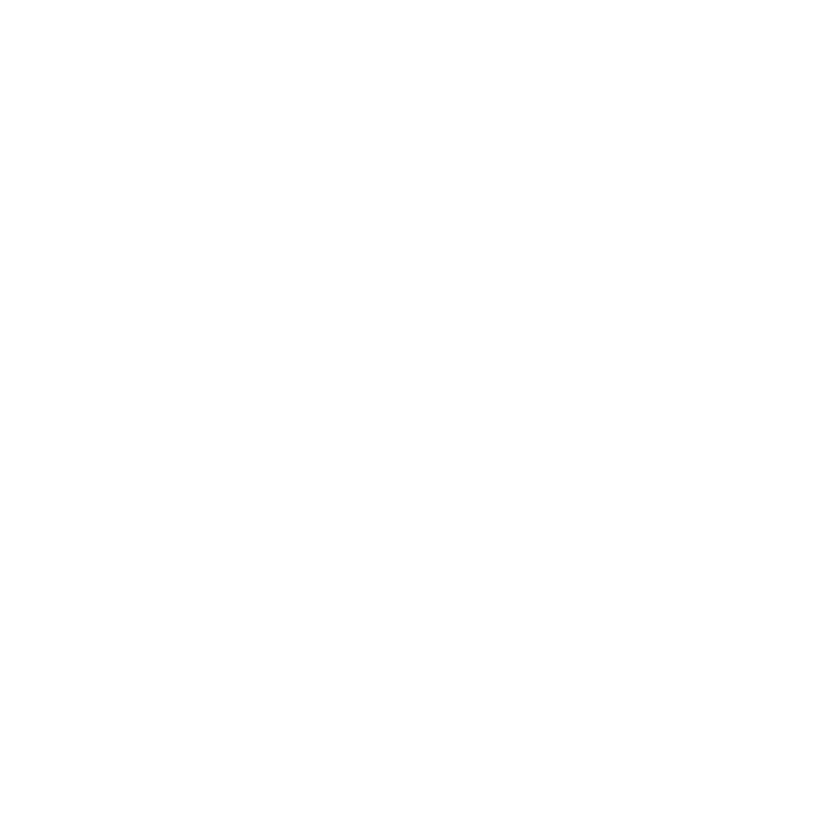

In [25]:
library(ggplot2)
errors<- colnames(data_graph)
ggplot(data = data_graph, mapping = aes(x=intercept, y=value, color=errors)) +
  geom_col()

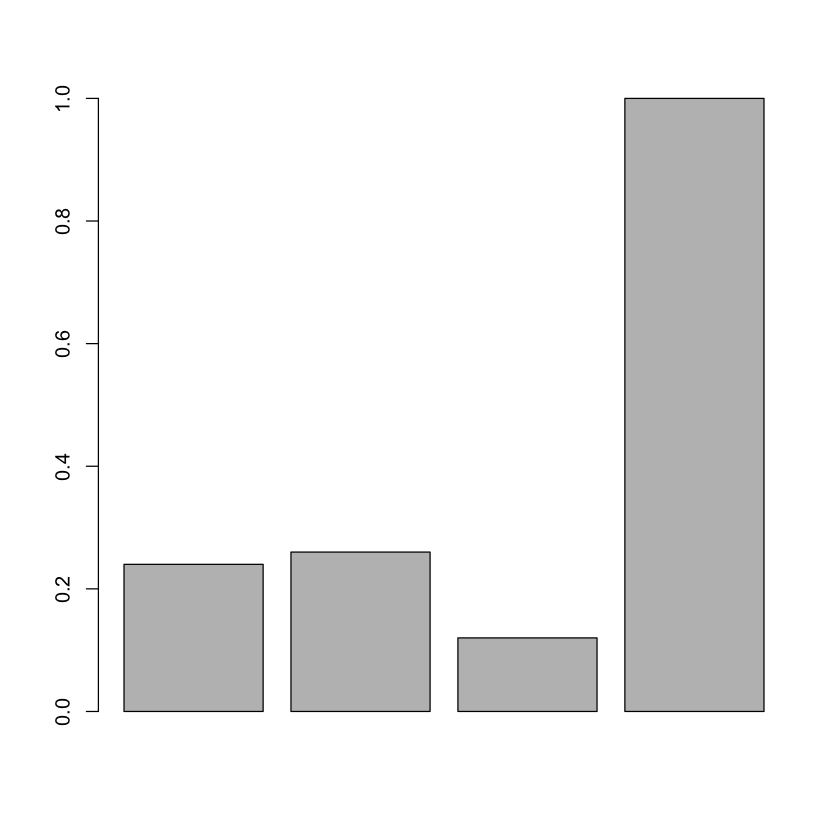

In [27]:
barplot(data_graph$T1_80)

In [18]:
delta.sim_(50, 40)

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

W